# Model Conceptuel de Stommel a 2 Boites

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact


In [6]:
# Paramètres du modèle (dilatation thermique α, contraction haline β, constante de flux K)
alpha = 2.0e-4    # diminution de densité par réchauffement de 1°C
beta = 8.0e-4     # augmentation de densité par augmentation de 1 PSU de salinité
K = 1.0           # constante de proportionnalité entre flux et différence de densité

# Fonction de simulation du modèle à deux boîtes (AMOC)
def simuler_modele_deux_boites(Temp_Nord, Sal_Nord_init, Temp_Sud, Sal_Sud_init,
                                Flux_eau_douce=0.0, debut_pulse=100, fin_pulse=150):
    """
    Simule le modèle à deux boîtes sur une période de temps fixe.
    Temp_Nord, Temp_Sud : températures des boîtes nord et sud (°C)
    Sal_Nord_init, Sal_Sud_init : salinités initiales des boîtes (PSU)
    Flux_eau_douce : flux d’eau douce ajouté (PSU/an) pendant la période de perturbation
    debut_pulse, fin_pulse : instants où commence et finit la perturbation
    """
    t_max = 200  # nombre total d'étapes temporelles
    Sal_Nord = Sal_Nord_init
    Sal_Sud = Sal_Sud_init
    Q_hist = []        # historique du flux Q
    Sal_Nord_hist = [] # historique salinité Nord
    Sal_Sud_hist = []  # historique salinité Sud

    for t in range(t_max):
        # Appliquer ou non le flux d’eau douce
        if debut_pulse <= t < fin_pulse:
            F = Flux_eau_douce
        else:
            F = 0.0
        
        # Calcul de la différence de densité Δρ = -α*(Tn-Ts) + β*(Sn-Ss)
        delta_rho = -alpha * (Temp_Nord - Temp_Sud) + beta * (Sal_Nord - Sal_Sud)
        Q = K * delta_rho  # flux AMOC, positif = nord → sud

        # Mise à jour des salinités (avec volumes égaux)
        dS_nord_dt = abs(Q) * (Sal_Sud - Sal_Nord) - F
        dS_sud_dt = abs(Q) * (Sal_Nord - Sal_Sud) + F

        Sal_Nord += dS_nord_dt
        Sal_Sud += dS_sud_dt

        Q_hist.append(Q)
        Sal_Nord_hist.append(Sal_Nord)
        Sal_Sud_hist.append(Sal_Sud)

    return np.arange(t_max), np.array(Q_hist), np.array(Sal_Nord_hist), np.array(Sal_Sud_hist)

# Fonction de tracé du modèle
def tracer_modele(Temp_Nord, Sal_Nord_init, Temp_Sud, Sal_Sud_init, Flux_eau_douce):
    t, Q_hist, Sal_Nord_hist, Sal_Sud_hist = simuler_modele_deux_boites(
        Temp_Nord, Sal_Nord_init, Temp_Sud, Sal_Sud_init, Flux_eau_douce
    )
    Q_final = Q_hist[-1]

    fig, axs = plt.subplots(2, 1, figsize=(6, 6))

    # --- (A) Schéma du modèle à deux boîtes ---
    ax = axs[0]
    ax.axis('off')
    ax.plot([0.1, 0.3, 0.3, 0.1, 0.1], [0.5, 0.5, 0.7, 0.7, 0.5], color='k')  # Boîte Nord
    ax.plot([0.7, 0.9, 0.9, 0.7, 0.7], [0.5, 0.5, 0.7, 0.7, 0.5], color='k')  # Boîte Sud

    ax.text(0.11, 0.72, f"Boîte Nord\nT={Temp_Nord}°C\nS≈{Sal_Nord_hist[-1]:.1f} PSU", fontsize=9)
    ax.text(0.71, 0.72, f"Boîte Sud\nT={Temp_Sud}°C\nS≈{Sal_Sud_hist[-1]:.1f} PSU", fontsize=9)

    # Flèche indiquant la direction du flux
    if Q_final >= 0:
        ax.annotate("", xy=(0.7, 0.6), xytext=(0.3, 0.6),
                    arrowprops=dict(facecolor='blue', width=2 + 5*abs(Q_final), headwidth=10))
        ax.text(0.45, 0.62, f"Flux AMOC Q = {Q_final:.3f}", color='blue')
    else:
        ax.annotate("", xy=(0.3, 0.6), xytext=(0.7, 0.6),
                    arrowprops=dict(facecolor='red', width=2 + 5*abs(Q_final), headwidth=10))
        ax.text(0.35, 0.62, f"Flux inversé Q = {Q_final:.3f}", color='red')

    ax.set_title("Schéma du modèle à deux boîtes", fontsize=10)

    # --- (B) Série temporelle du flux Q ---
    axs[1].plot(t, Q_hist, label='Flux méridien Q')
    axs[1].axvspan(100, 150, color='cyan', alpha=0.3, label='Pulse d’eau douce')
    axs[1].set_xlabel("Temps (unités arbitraires)")
    axs[1].set_ylabel("Flux $Q$ (unités arbitraires)")
    axs[1].set_title("Évolution de la force de l’AMOC")
    axs[1].legend(loc='best')

    plt.tight_layout()
    plt.show()


interact(tracer_modele, 
         Temp_Nord=(0, 25, 1), Sal_Nord_init=(30, 40, 0.5),
         Temp_Sud=(0, 25, 1), Sal_Sud_init=(30, 40, 0.5),
         Flux_eau_douce=(0.0, 2.0, 0.1))


interactive(children=(IntSlider(value=12, description='Temp_Nord', max=25), FloatSlider(value=35.0, descriptio…

<function __main__.tracer_modele(Temp_Nord, Sal_Nord_init, Temp_Sud, Sal_Sud_init, Flux_eau_douce)>

# Etude en 2 points strategiques : Florida Straights et Labrador Sea

In [7]:
file_path = "data/schmidt2011.xls"  


florida  = pd.read_excel(file_path, header=1, engine="xlrd")  

florida.columns = ["Depth_cm", "Age_kyrBP", "G_ruber_d18Oc", "IVF_d18Oc", "Mg_Ca_mmolmol", "SST_C", "IVF_d18Osw", "Ba_Ca_mmolmol"]
florida.head()

,Depth_cm,Age_kyrBP,G_ruber_d18Oc,IVF_d18Oc,Mg_Ca_mmolmol,SST_C,IVF_d18Osw,Ba_Ca_mmolmol
0,0.75,0.64,NaN,NaN,4.57,27.6,NaN,0.91
1,8.25,0.97,NaN,NaN,4.36,27.1,NaN,0.88
2,32.25,2.04,NaN,NaN,4.78,28.1,NaN,0.90
3,48.25,2.76,NaN,NaN,4.28,26.9,NaN,0.87
4,56.25,3.32,NaN,NaN,4.76,28.1,NaN,NaN


In [8]:
url_lab = "https://www.ncei.noaa.gov/pub/data/paleo/contributions_by_author/hoffman2018/hoffman2016-008twc-isotope.txt"

usecols = ["Marine13_age", "d18O_Nps_IVC" , "d18O_Ct_IVC"]

labrador = pd.read_csv(url_lab, sep='\t', comment='#',usecols=usecols)
labrador = labrador.replace("N/A", pd.NA).dropna()

lab_strat = labrador.copy()


labrador["Marine13_age"] = pd.to_numeric(labrador["Marine13_age"])
labrador["d18O_Nps_IVC"] = pd.to_numeric(labrador["d18O_Nps_IVC"])


labrador["Age_kyrBP"] = labrador["Marine13_age"] / 1000

lab = labrador[(labrador["Age_kyrBP"] <= 19) & (labrador["Age_kyrBP"] >= 10)].sort_values(by="Age_kyrBP")
labrador


,Marine13_age,d18O_Nps_IVC,d18O_Ct_IVC,Age_kyrBP
5,10984,2.83,3.87,10.984
6,12781,3.20,3.79,12.781
7,13500,2.99,3.69,13.500
8,14219,3.00,3.71,14.219
9,14255,3.02,3.63,14.255
10,14291,2.84,3.70,14.291
11,14328,2.82,3.45,14.328
12,14364,2.78,3.67,14.364
13,14400,2.93,3.65,14.400
14,14436,2.76,3.65,14.436


/var/folders/9_/8zlygvj51hgd9txj3d037_s00000gn/T/ipykernel_68841/353718389.py:4: RankWarning: Polyfit may be poorly conditioned
  coeffs_gruber = np.polyfit(florida["Age_kyrBP"], florida["G_ruber_d18Oc"], 18)


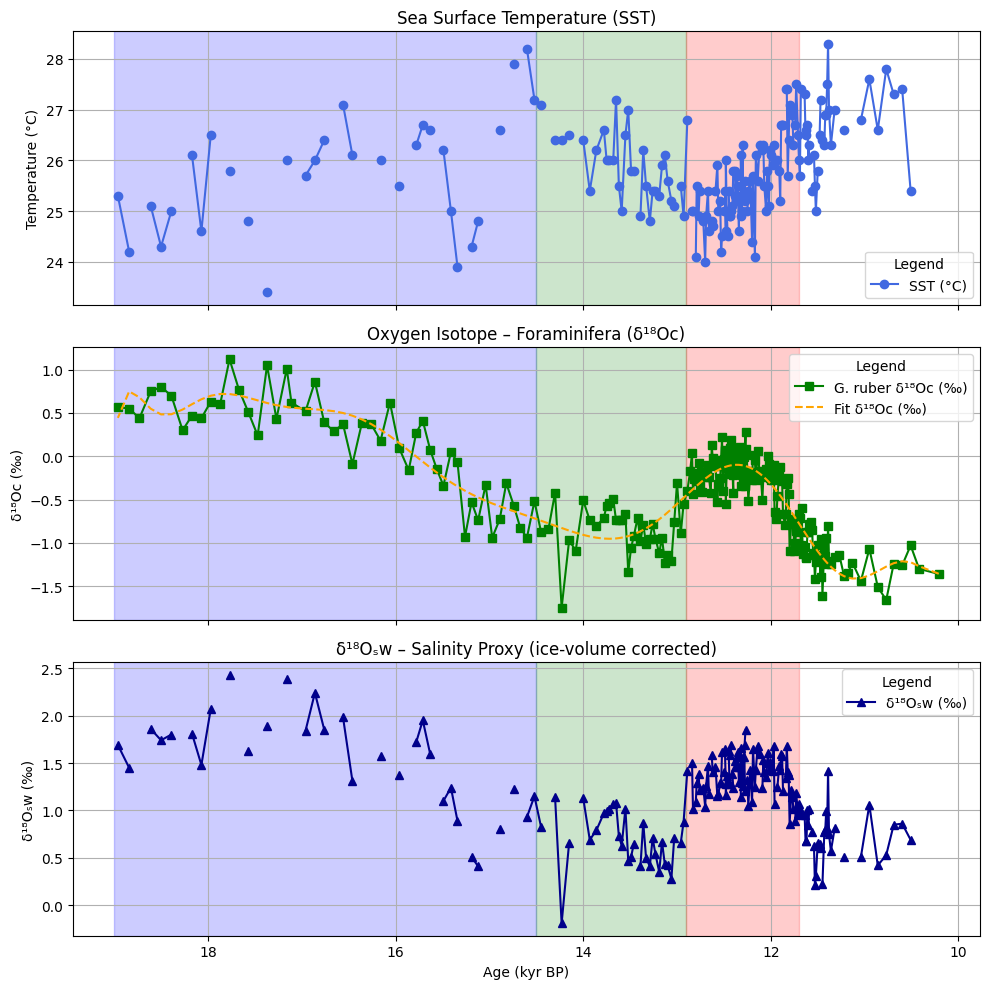

In [9]:
florida = florida[(florida["Age_kyrBP"] <= 19) & (florida["Age_kyrBP"] >= 10)]
florida = florida.sort_values(by="Age_kyrBP")

coeffs_gruber = np.polyfit(florida["Age_kyrBP"], florida["G_ruber_d18Oc"], 18)
poly_eq_gruber = np.poly1d(coeffs_gruber)
fit_line_gruber = poly_eq_gruber(florida["Age_kyrBP"])

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axes[0].plot(florida["Age_kyrBP"], florida["SST_C"], marker='o', linestyle='-', color='royalblue', label="SST (°C)")
axes[0].set_ylabel("Temperature (°C)")
axes[0].set_title("Sea Surface Temperature (SST)")
axes[0].legend(title="Legend")

axes[1].plot(florida["Age_kyrBP"], florida["G_ruber_d18Oc"], marker='s', linestyle='-', color='green', label="G. ruber δ¹⁸Oc (‰)")
axes[1].plot(florida["Age_kyrBP"], fit_line_gruber, linestyle='--', color='orange', label="Fit δ¹⁸Oc (‰)")
axes[1].set_ylabel("δ¹⁸Oc (‰)")
axes[1].set_title("Oxygen Isotope – Foraminifera (δ¹⁸Oc)")
axes[1].legend(title="Legend")

axes[2].plot(florida["Age_kyrBP"], florida["IVF_d18Osw"], marker='^', linestyle='-', color='darkblue', label="δ¹⁸Oₛw (‰)")
axes[2].set_ylabel("δ¹⁸Oₛw (‰)")
axes[2].set_xlabel("Age (kyr BP)")
axes[2].set_title("δ¹⁸Oₛw – Salinity Proxy (ice-volume corrected)")
axes[2].legend(title="Legend")


for ax in axes:
    ax.axvspan(19, 14.5, color='blue', alpha=0.2, label=None)   
    ax.axvspan(14.5, 12.9, color='green', alpha=0.2, label=None)  
    ax.axvspan(12.9, 11.7, color='red', alpha=0.2, label=None)  
    ax.invert_xaxis()
    ax.grid(True)

plt.tight_layout()
plt.show()


/var/folders/9_/8zlygvj51hgd9txj3d037_s00000gn/T/ipykernel_68841/1754805717.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs_lab = np.polyfit(lab["Age_kyrBP"], lab["d18O_Nps_IVC"], 18)


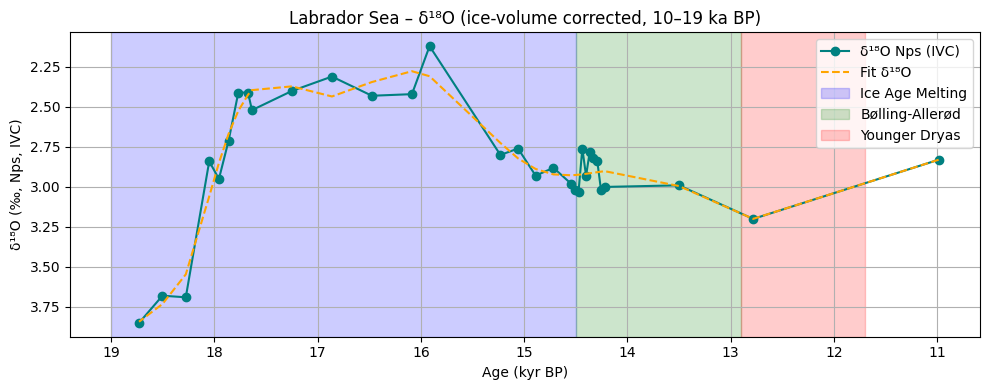

In [ ]:
lab = labrador[(labrador["Age_kyrBP"] >= 10) & (labrador["Age_kyrBP"] <= 19)].sort_values("Age_kyrBP")

coeffs_lab = np.polyfit(lab["Age_kyrBP"], lab["d18O_Nps_IVC"], 18)
poly_eq_lab = np.poly1d(coeffs_lab)
fit_line_lab = poly_eq_lab(lab["Age_kyrBP"])

plt.figure(figsize=(10, 4))
plt.plot(lab["Age_kyrBP"], lab["d18O_Nps_IVC"], marker='o', linestyle='-', color='teal', label="δ¹⁸O Nps (IVC)")
plt.plot(lab["Age_kyrBP"], fit_line_lab, linestyle='--', color='orange', label="Fit δ¹⁸O")

plt.axvspan(19, 14.5, color='blue', alpha=0.2, label="Ice Age Melting")
plt.axvspan(14.5, 12.9, color='green', alpha=0.2, label="Bølling-Allerød")
plt.axvspan(12.9, 11.7, color='red', alpha=0.2, label="Younger Dryas")

plt.xlabel("Age (kyr BP)")
plt.ylabel("δ¹⁸O (‰, Nps, IVC)")
plt.title("Labrador Sea – δ¹⁸O (ice-volume corrected, 10–19 ka BP)")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

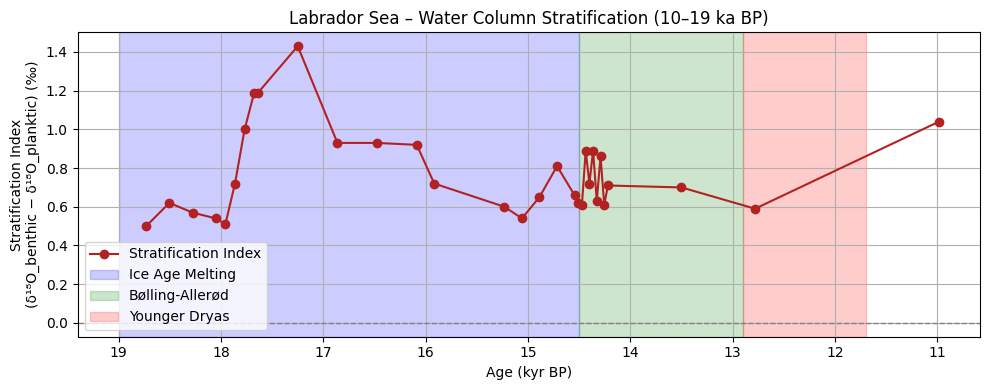

In [10]:
lab_strat["d18O_Nps_IVC"] = pd.to_numeric(lab_strat["d18O_Nps_IVC"], errors="coerce")
lab_strat["d18O_Ct_IVC"] = pd.to_numeric(lab_strat["d18O_Ct_IVC"], errors="coerce")
lab_strat["Age_kyrBP"] = lab_strat["Marine13_age"] / 1000

lab_strat = lab_strat.dropna(subset=["d18O_Nps_IVC", "d18O_Ct_IVC"])

lab_strat["Strat_Index"] = lab_strat["d18O_Ct_IVC"] - lab_strat["d18O_Nps_IVC"]

lab_strat = lab_strat[(lab_strat["Age_kyrBP"] >= 10) & (lab_strat["Age_kyrBP"] <= 19)]

plt.figure(figsize=(10, 4))
plt.plot(lab_strat["Age_kyrBP"], lab_strat["Strat_Index"], marker='o', linestyle='-', color='firebrick', label="Stratification Index")

plt.axvspan(19, 14.5, color='blue', alpha=0.2, label="Ice Age Melting")
plt.axvspan(14.5, 12.9, color='green', alpha=0.2, label="Bølling-Allerød")
plt.axvspan(12.9, 11.7, color='red', alpha=0.2, label="Younger Dryas")

plt.xlabel("Age (kyr BP)")
plt.ylabel("Stratification Index\n(δ¹⁸O_benthic − δ¹⁸O_planktic) (‰)")
plt.title("Labrador Sea – Water Column Stratification (10–19 ka BP)")
plt.gca().invert_xaxis()
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()